In [5]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms

# Define data augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for CIFAR-100
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-100 dataset
full_dataset = CIFAR100(root="./data", train=True, download=True)

# Split the dataset into training, validation, and testing sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transforms to datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform  # Use the same transform as the validation set for the test set

# Create data loaders
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_classes = 100  # CIFAR-100 has 100 classes
lr = 0.003 #1e-4
patch_size = 4 #8
num_layers = 12
num_heads = 16 #12
hidden_dim = 512 #768
mlp_dim = 3072
image_size = 32
# max_len = 100 # All sequences must be less than 1000 including class token
# channels = 3

num_epochs = 60

# Model, loss, and optimizer
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights).to(device)
#model = resnet50(num_classes=num_classes, image_size=image_size, patch_size=patch_size, num_layers=num_layers, num_heads=num_heads, hidden_dim=hidden_dim, mlp_dim=mlp_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Optional: learning rate scheduler
best_accuracy = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Optional: Adjust learning rate
    scheduler.step()

    # Print average loss per epoch
    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    total_val_loss = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()

    val_accuracy = correct / total
    average_val_loss = total_val_loss / len(val_loader)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%, , Validation Loss: {average_val_loss:.4f}")

    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      # Save the trained model
      torch.save(model.state_dict(), "resnet_model.pth")

Epoch 1/60: 100%|██████████| 137/137 [00:17<00:00,  8.01it/s]


Epoch 1/60, Loss: 4.4229


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.39it/s]


Validation Accuracy: 17.46%, , Validation Loss: 3.4106


Epoch 2/60: 100%|██████████| 137/137 [00:17<00:00,  8.01it/s]


Epoch 2/60, Loss: 2.7844


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.55it/s]


Validation Accuracy: 33.31%, , Validation Loss: 2.6485


Epoch 3/60: 100%|██████████| 137/137 [00:17<00:00,  7.95it/s]


Epoch 3/60, Loss: 2.1592


Validation: 100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


Validation Accuracy: 38.73%, , Validation Loss: 2.3666


Epoch 4/60: 100%|██████████| 137/137 [00:16<00:00,  8.24it/s]


Epoch 4/60, Loss: 1.7594


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.25it/s]


Validation Accuracy: 40.30%, , Validation Loss: 2.3759


Epoch 5/60: 100%|██████████| 137/137 [00:16<00:00,  8.27it/s]


Epoch 5/60, Loss: 1.4737


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.20it/s]


Validation Accuracy: 43.83%, , Validation Loss: 2.2546


Epoch 6/60: 100%|██████████| 137/137 [00:17<00:00,  8.05it/s]


Epoch 6/60, Loss: 0.9406


Validation: 100%|██████████| 40/40 [00:03<00:00, 12.63it/s]


Validation Accuracy: 52.44%, , Validation Loss: 1.9397


Epoch 7/60: 100%|██████████| 137/137 [00:16<00:00,  8.10it/s]


Epoch 7/60, Loss: 0.6257


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.43it/s]


Validation Accuracy: 52.15%, , Validation Loss: 2.0455


Epoch 8/60: 100%|██████████| 137/137 [00:16<00:00,  8.19it/s]


Epoch 8/60, Loss: 0.4902


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.25it/s]


Validation Accuracy: 51.15%, , Validation Loss: 2.2879


Epoch 9/60: 100%|██████████| 137/137 [00:16<00:00,  8.13it/s]


Epoch 9/60, Loss: 0.4275


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.40it/s]


Validation Accuracy: 50.77%, , Validation Loss: 2.4003


Epoch 10/60: 100%|██████████| 137/137 [00:16<00:00,  8.14it/s]


Epoch 10/60, Loss: 0.3561


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.36it/s]


Validation Accuracy: 51.56%, , Validation Loss: 2.4920


Epoch 11/60: 100%|██████████| 137/137 [00:17<00:00,  8.05it/s]


Epoch 11/60, Loss: 0.1605


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.35it/s]


Validation Accuracy: 54.92%, , Validation Loss: 2.4300


Epoch 12/60: 100%|██████████| 137/137 [00:16<00:00,  8.26it/s]


Epoch 12/60, Loss: 0.0485


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.85it/s]


Validation Accuracy: 55.58%, , Validation Loss: 2.5858


Epoch 13/60: 100%|██████████| 137/137 [00:16<00:00,  8.17it/s]


Epoch 13/60, Loss: 0.0206


Validation: 100%|██████████| 40/40 [00:03<00:00, 12.25it/s]


Validation Accuracy: 55.89%, , Validation Loss: 2.7036


Epoch 14/60: 100%|██████████| 137/137 [00:17<00:00,  7.95it/s]


Epoch 14/60, Loss: 0.0110


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


Validation Accuracy: 56.01%, , Validation Loss: 2.8039


Epoch 15/60: 100%|██████████| 137/137 [00:16<00:00,  8.17it/s]


Epoch 15/60, Loss: 0.0088


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.87it/s]


Validation Accuracy: 55.54%, , Validation Loss: 2.9413


Epoch 16/60: 100%|██████████| 137/137 [00:16<00:00,  8.06it/s]


Epoch 16/60, Loss: 0.0055


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.38it/s]


Validation Accuracy: 55.95%, , Validation Loss: 2.9435


Epoch 17/60: 100%|██████████| 137/137 [00:16<00:00,  8.14it/s]


Epoch 17/60, Loss: 0.0030


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.25it/s]


Validation Accuracy: 56.05%, , Validation Loss: 3.0326


Epoch 18/60: 100%|██████████| 137/137 [00:16<00:00,  8.18it/s]


Epoch 18/60, Loss: 0.0024


Validation: 100%|██████████| 40/40 [00:03<00:00, 12.38it/s]


Validation Accuracy: 56.30%, , Validation Loss: 3.0768


Epoch 19/60: 100%|██████████| 137/137 [00:17<00:00,  7.92it/s]


Epoch 19/60, Loss: 0.0016


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.94it/s]


Validation Accuracy: 56.42%, , Validation Loss: 3.1125


Epoch 20/60: 100%|██████████| 137/137 [00:16<00:00,  8.19it/s]


Epoch 20/60, Loss: 0.0014


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.90it/s]


Validation Accuracy: 56.29%, , Validation Loss: 3.1837


Epoch 21/60: 100%|██████████| 137/137 [00:16<00:00,  8.17it/s]


Epoch 21/60, Loss: 0.0011


Validation: 100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


Validation Accuracy: 56.46%, , Validation Loss: 3.2188


Epoch 22/60: 100%|██████████| 137/137 [00:16<00:00,  8.23it/s]


Epoch 22/60, Loss: 0.0011


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.20it/s]


Validation Accuracy: 56.47%, , Validation Loss: 3.2230


Epoch 23/60: 100%|██████████| 137/137 [00:18<00:00,  7.60it/s]


Epoch 23/60, Loss: 0.0012


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.94it/s]


Validation Accuracy: 56.56%, , Validation Loss: 3.2825


Epoch 24/60: 100%|██████████| 137/137 [00:16<00:00,  8.25it/s]


Epoch 24/60, Loss: 0.0010


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.78it/s]


Validation Accuracy: 56.44%, , Validation Loss: 3.2816


Epoch 25/60: 100%|██████████| 137/137 [00:16<00:00,  8.18it/s]


Epoch 25/60, Loss: 0.0009


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.77it/s]


Validation Accuracy: 56.50%, , Validation Loss: 3.3196


Epoch 26/60: 100%|██████████| 137/137 [00:17<00:00,  7.94it/s]


Epoch 26/60, Loss: 0.0007


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


Validation Accuracy: 56.42%, , Validation Loss: 3.3409


Epoch 27/60: 100%|██████████| 137/137 [00:16<00:00,  8.20it/s]


Epoch 27/60, Loss: 0.0007


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.96it/s]


Validation Accuracy: 56.50%, , Validation Loss: 3.3445


Epoch 28/60: 100%|██████████| 137/137 [00:16<00:00,  8.18it/s]


Epoch 28/60, Loss: 0.0006


Validation: 100%|██████████| 40/40 [00:04<00:00,  9.96it/s]


Validation Accuracy: 56.68%, , Validation Loss: 3.3638


Epoch 29/60: 100%|██████████| 137/137 [00:17<00:00,  8.04it/s]


Epoch 29/60, Loss: 0.0007


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.87it/s]


Validation Accuracy: 56.38%, , Validation Loss: 3.4036


Epoch 30/60: 100%|██████████| 137/137 [00:16<00:00,  8.17it/s]


Epoch 30/60, Loss: 0.0006


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.76it/s]


Validation Accuracy: 56.58%, , Validation Loss: 3.4151


Epoch 31/60: 100%|██████████| 137/137 [00:17<00:00,  7.97it/s]


Epoch 31/60, Loss: 0.0006


Validation: 100%|██████████| 40/40 [00:03<00:00, 12.55it/s]


Validation Accuracy: 56.40%, , Validation Loss: 3.4057


Epoch 32/60: 100%|██████████| 137/137 [00:16<00:00,  8.17it/s]


Epoch 32/60, Loss: 0.0005


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.17it/s]


Validation Accuracy: 56.46%, , Validation Loss: 3.4158


Epoch 33/60: 100%|██████████| 137/137 [00:16<00:00,  8.18it/s]


Epoch 33/60, Loss: 0.0005


Validation: 100%|██████████| 40/40 [00:03<00:00, 11.71it/s]


Validation Accuracy: 56.51%, , Validation Loss: 3.4520


Epoch 34/60: 100%|██████████| 137/137 [00:17<00:00,  8.00it/s]


Epoch 34/60, Loss: 0.0006


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.42it/s]


Validation Accuracy: 56.52%, , Validation Loss: 3.4353


Epoch 35/60: 100%|██████████| 137/137 [00:16<00:00,  8.13it/s]


Epoch 35/60, Loss: 0.0005


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.87it/s]


Validation Accuracy: 56.57%, , Validation Loss: 3.4231


Epoch 36/60: 100%|██████████| 137/137 [00:16<00:00,  8.16it/s]


Epoch 36/60, Loss: 0.0005


Validation: 100%|██████████| 40/40 [00:03<00:00, 10.46it/s]


Validation Accuracy: 56.64%, , Validation Loss: 3.4629


Epoch 37/60: 100%|██████████| 137/137 [00:16<00:00,  8.15it/s]


Epoch 37/60, Loss: 0.0006


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


Validation Accuracy: 56.63%, , Validation Loss: 3.4136


Epoch 38/60: 100%|██████████| 137/137 [00:16<00:00,  8.09it/s]


Epoch 38/60, Loss: 0.0005


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.13it/s]


Validation Accuracy: 56.61%, , Validation Loss: 3.4592


Epoch 39/60:  17%|█▋        | 23/137 [00:03<00:18,  6.13it/s]


KeyboardInterrupt: ignored

In [8]:
# Evaluation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 20/20 [00:01<00:00, 12.99it/s]

Test Accuracy: 56.10%


In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same transformations as used during training
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-100 test dataset
test_dataset = CIFAR100(root="./data", train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Initialize the model
model = resnet50().to(device)

# Load the saved weights
model.load_state_dict(torch.load("resnet_model.pth"))
model.eval()

# Evaluation loop
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Files already downloaded and verified


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 14.15it/s]

Test Accuracy: 57.02%


Files already downloaded and verified
Predicted Class: lion


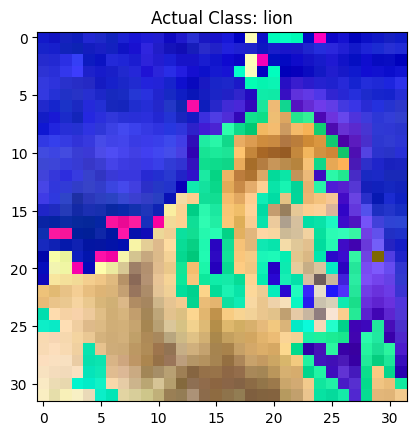

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the same transformations as used during training
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-100 test dataset
test_dataset = CIFAR100(root="./data", train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

# Initialize the model
model = resnet50().to(device)

# Load the saved weights
model.load_state_dict(torch.load("resnet_model.pth"))
model.eval()

# Pick a random image from the test set
image, label = test_dataset[15]

# Add a batch dimension since the model expects a batch
image = image.unsqueeze(0).to(device)

# Forward pass
with torch.no_grad():
    output = model(image)

# Get the predicted class index
_, predicted_class = torch.max(output, 1)

# Print the predicted class label
print(f"Predicted Class: {test_dataset.classes[predicted_class.item()]}")

# Visualize the image
image = transforms.ToPILImage()(image.squeeze().cpu())
plt.imshow(image)
plt.title("Actual Class: " + test_dataset.classes[label])
plt.show()
